In this notebook, the yield distributions of the ScopeBO-selected scopes are compared for the unpruned and pruned decarboxylation bromide datasets.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pathlib import Path
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Code.benchmark import Benchmark
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.legend_handler import HandlerTuple
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
})

Look at the yield distributions separately for each dataset.

In [2]:
def yield_cat_distribution(name_results, norm_axis=50, title = None,
                            bins = [-1000, 0, 10, 1000], labels=['0', '0< yield ≤10', '>10'], 
                            directory=".", suppress_plot = False, figwidth = 5, barwidth = 0.4,
                            text_height = 2, text_col = "white"):
    """Function to visualize the yield distributions for different yield bins. 
    Shows the fraction of the samples in the respective yield bin as a barplot with whiskers showing the standard deviation."""

    wdir = Path(directory)
    raw_path = wdir / name_results / "raw_data"

    # find the objectives
    objectives = Benchmark.find_objectives(name_results,directory)

    # list to store the fraction results
    all_fractions = []

    # go through all the raw files in the original folder
    for file in os.listdir(raw_path):
        # read in the raw data file
        df_raw = pd.read_csv(raw_path / file, index_col = 0, header = 0)

        # get the objective values of each entry
        df_raw[f"obj_values {objectives}"] = df_raw[f"obj_values {objectives}"].apply(ast.literal_eval)
        obj_values = [value for round_list in [df_raw.loc[round,f"obj_values {objectives}"] for round in df_raw.index] for value in round_list]
        binned = pd.cut(obj_values, bins=bins, labels=labels, right=True, include_lowest=True)
        counts = binned.value_counts().sort_index()
        # convert to fractions and save
        all_fractions.append(counts.apply(lambda x: x/sum(counts)*100))
    df_fractions = pd.DataFrame(all_fractions).fillna(0)
    means = df_fractions.mean()
    stdevs = df_fractions.std(ddof=1)  # stdev using Bessel's correction
    x = np.arange(len(labels))

    if not suppress_plot:
        plt.figure(figsize=(figwidth, 3), dpi=600)
        plt.bar(x, means, barwidth, yerr=stdevs, capsize = 5, color=all_colors[0], edgecolor='k')
        plt.xticks(x, labels)
        plt.ylabel('Fraction (%)')
        plt.ylim(0,norm_axis)
        plt.xlabel('Yield (%)')
        # Add values
        for i, v in enumerate(means):
            plt.text(x[i], text_height, f'{v:.1f}', ha='center', va='bottom', fontsize=12, c =text_col)
        if title is not None:
            plt.title(title)
        plt.show()

    return df_fractions

distribution of the yields for ScopeBO scopes for the unpruned dataset


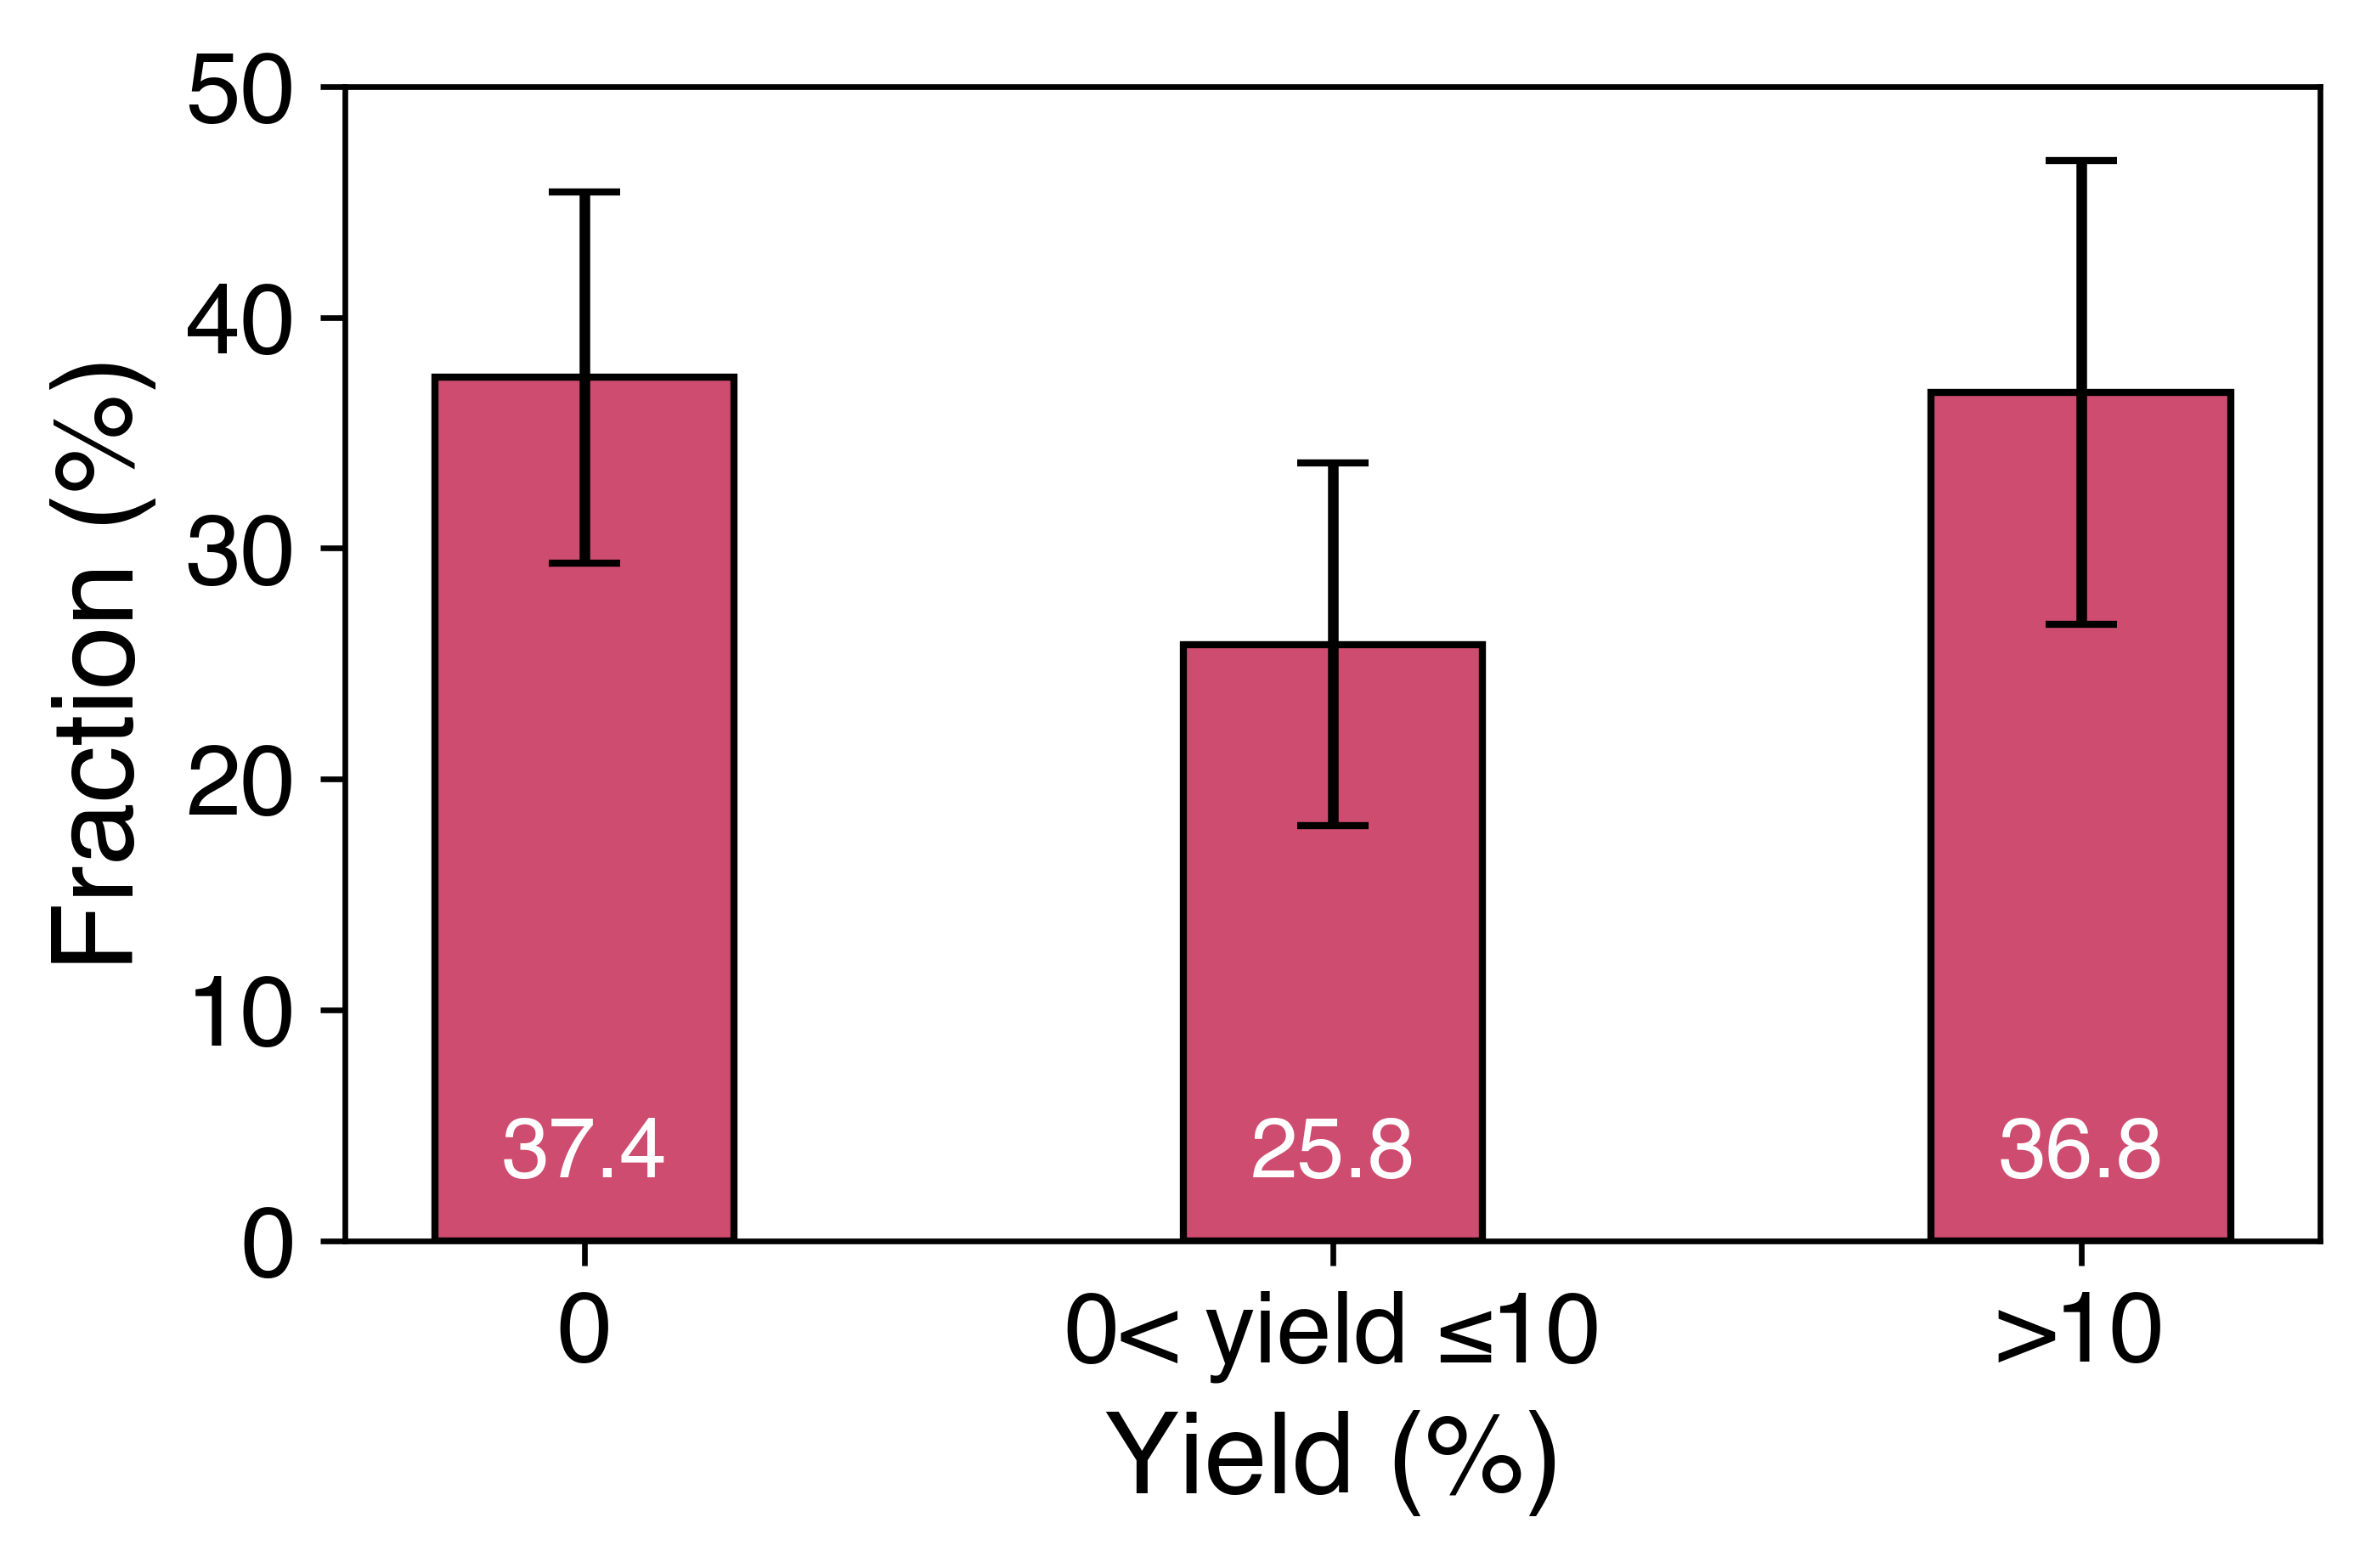

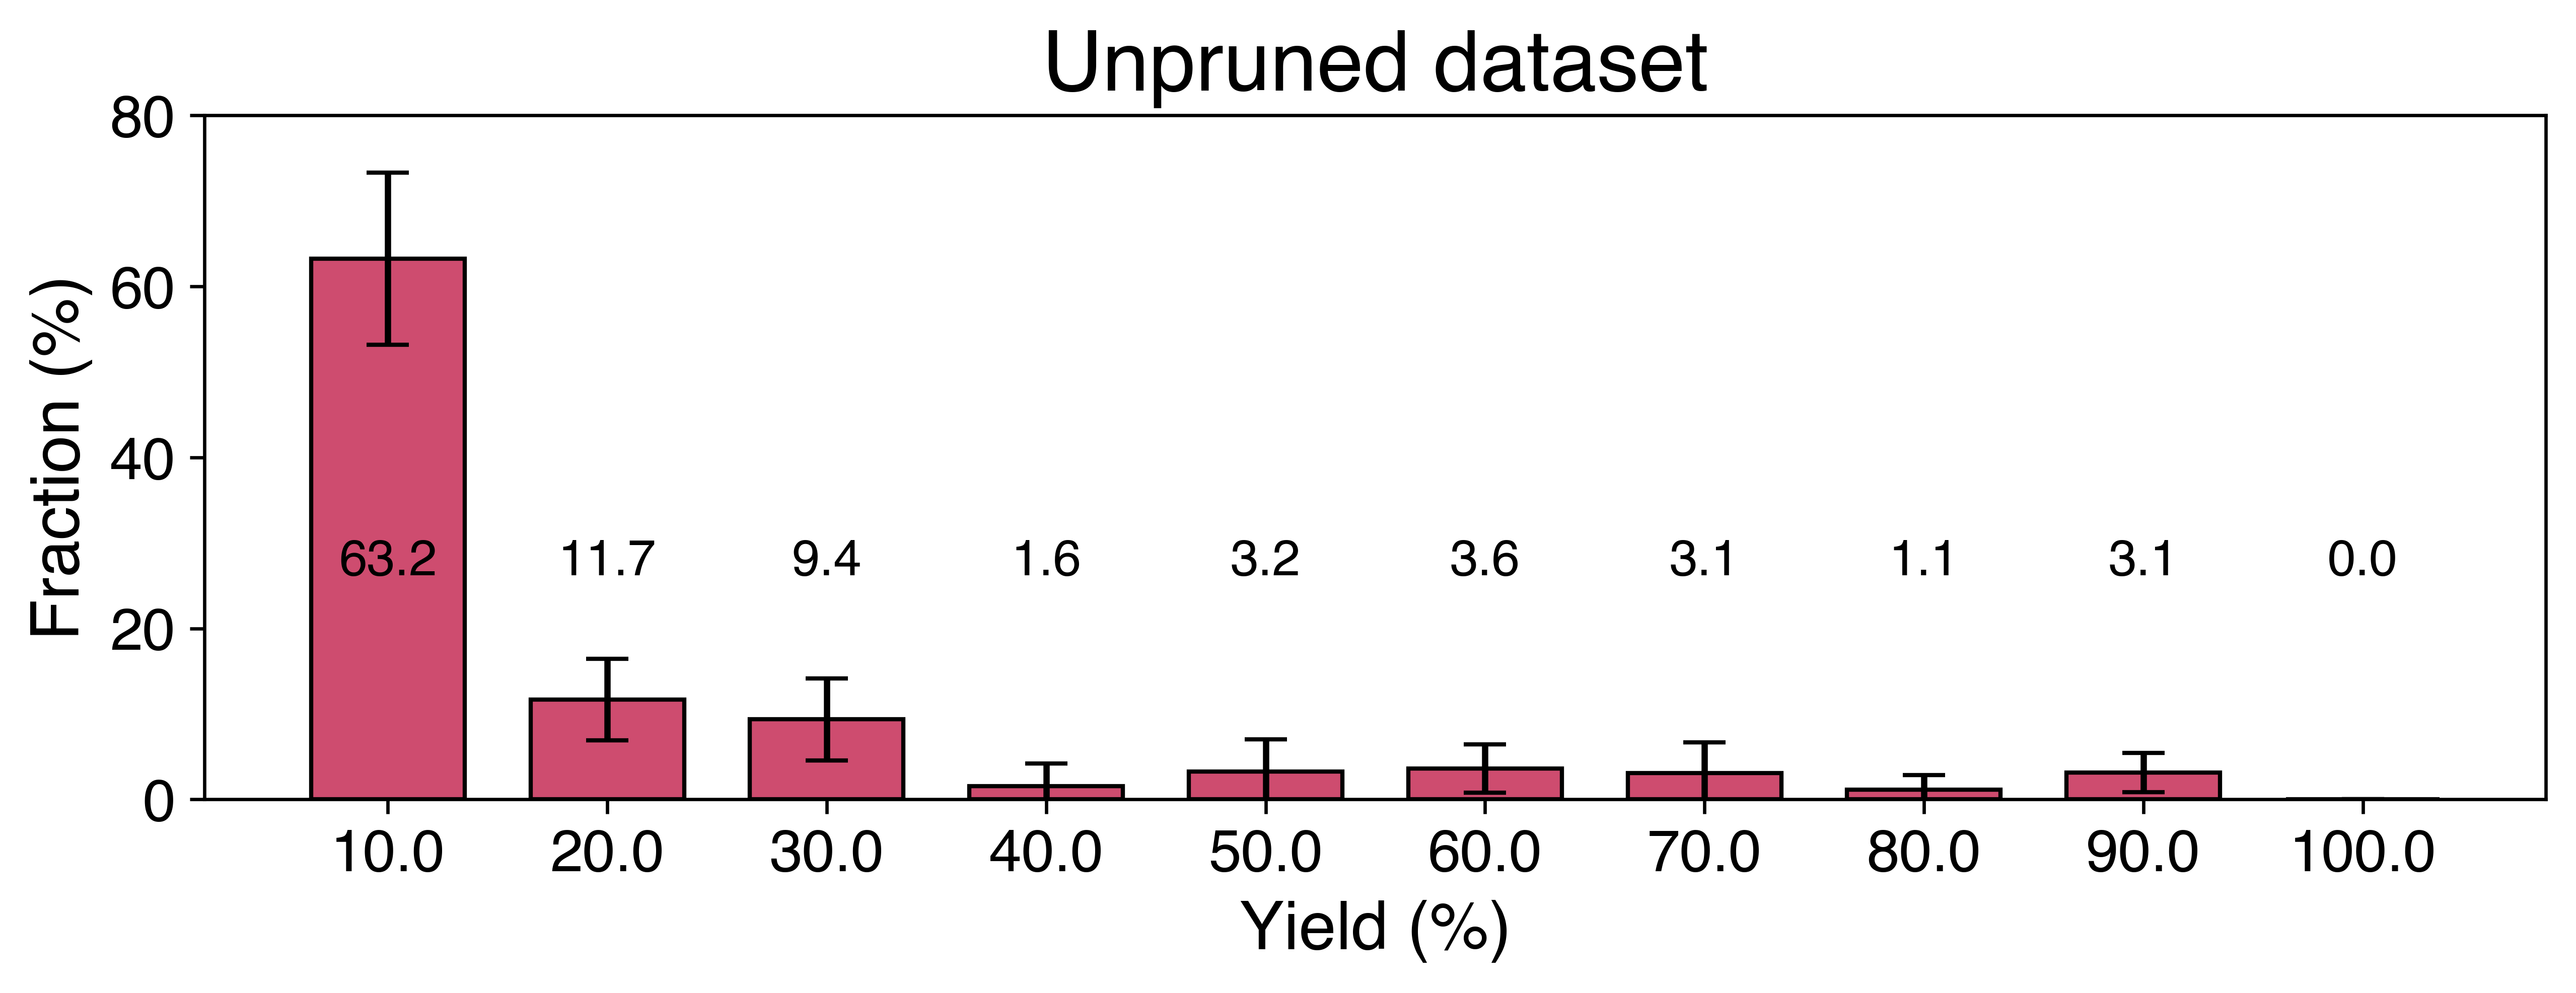

In [3]:
print("distribution of the yields for ScopeBO scopes for the unpruned dataset")
df_counts_original = Benchmark().objective_distribution(name_results="./Results_Data/results_unpruned/scope_ei_with-pruning",print_figure=False)
df_fractions_original = yield_cat_distribution(name_results="./Results_Data/results_unpruned/scope_ei_with-pruning")
_ = yield_cat_distribution(name_results="./Results_Data/results_unpruned/scope_ei_with-pruning", title = "Unpruned dataset",
                           bins = np.linspace(0,100,11), labels =  np.linspace(0,100,11)[1:], norm_axis=80,
                           figwidth = 10, barwidth = 0.7, text_height = 25, text_col = "k")



distribution of the yields for ScopeBO scopes for the pruned dataset


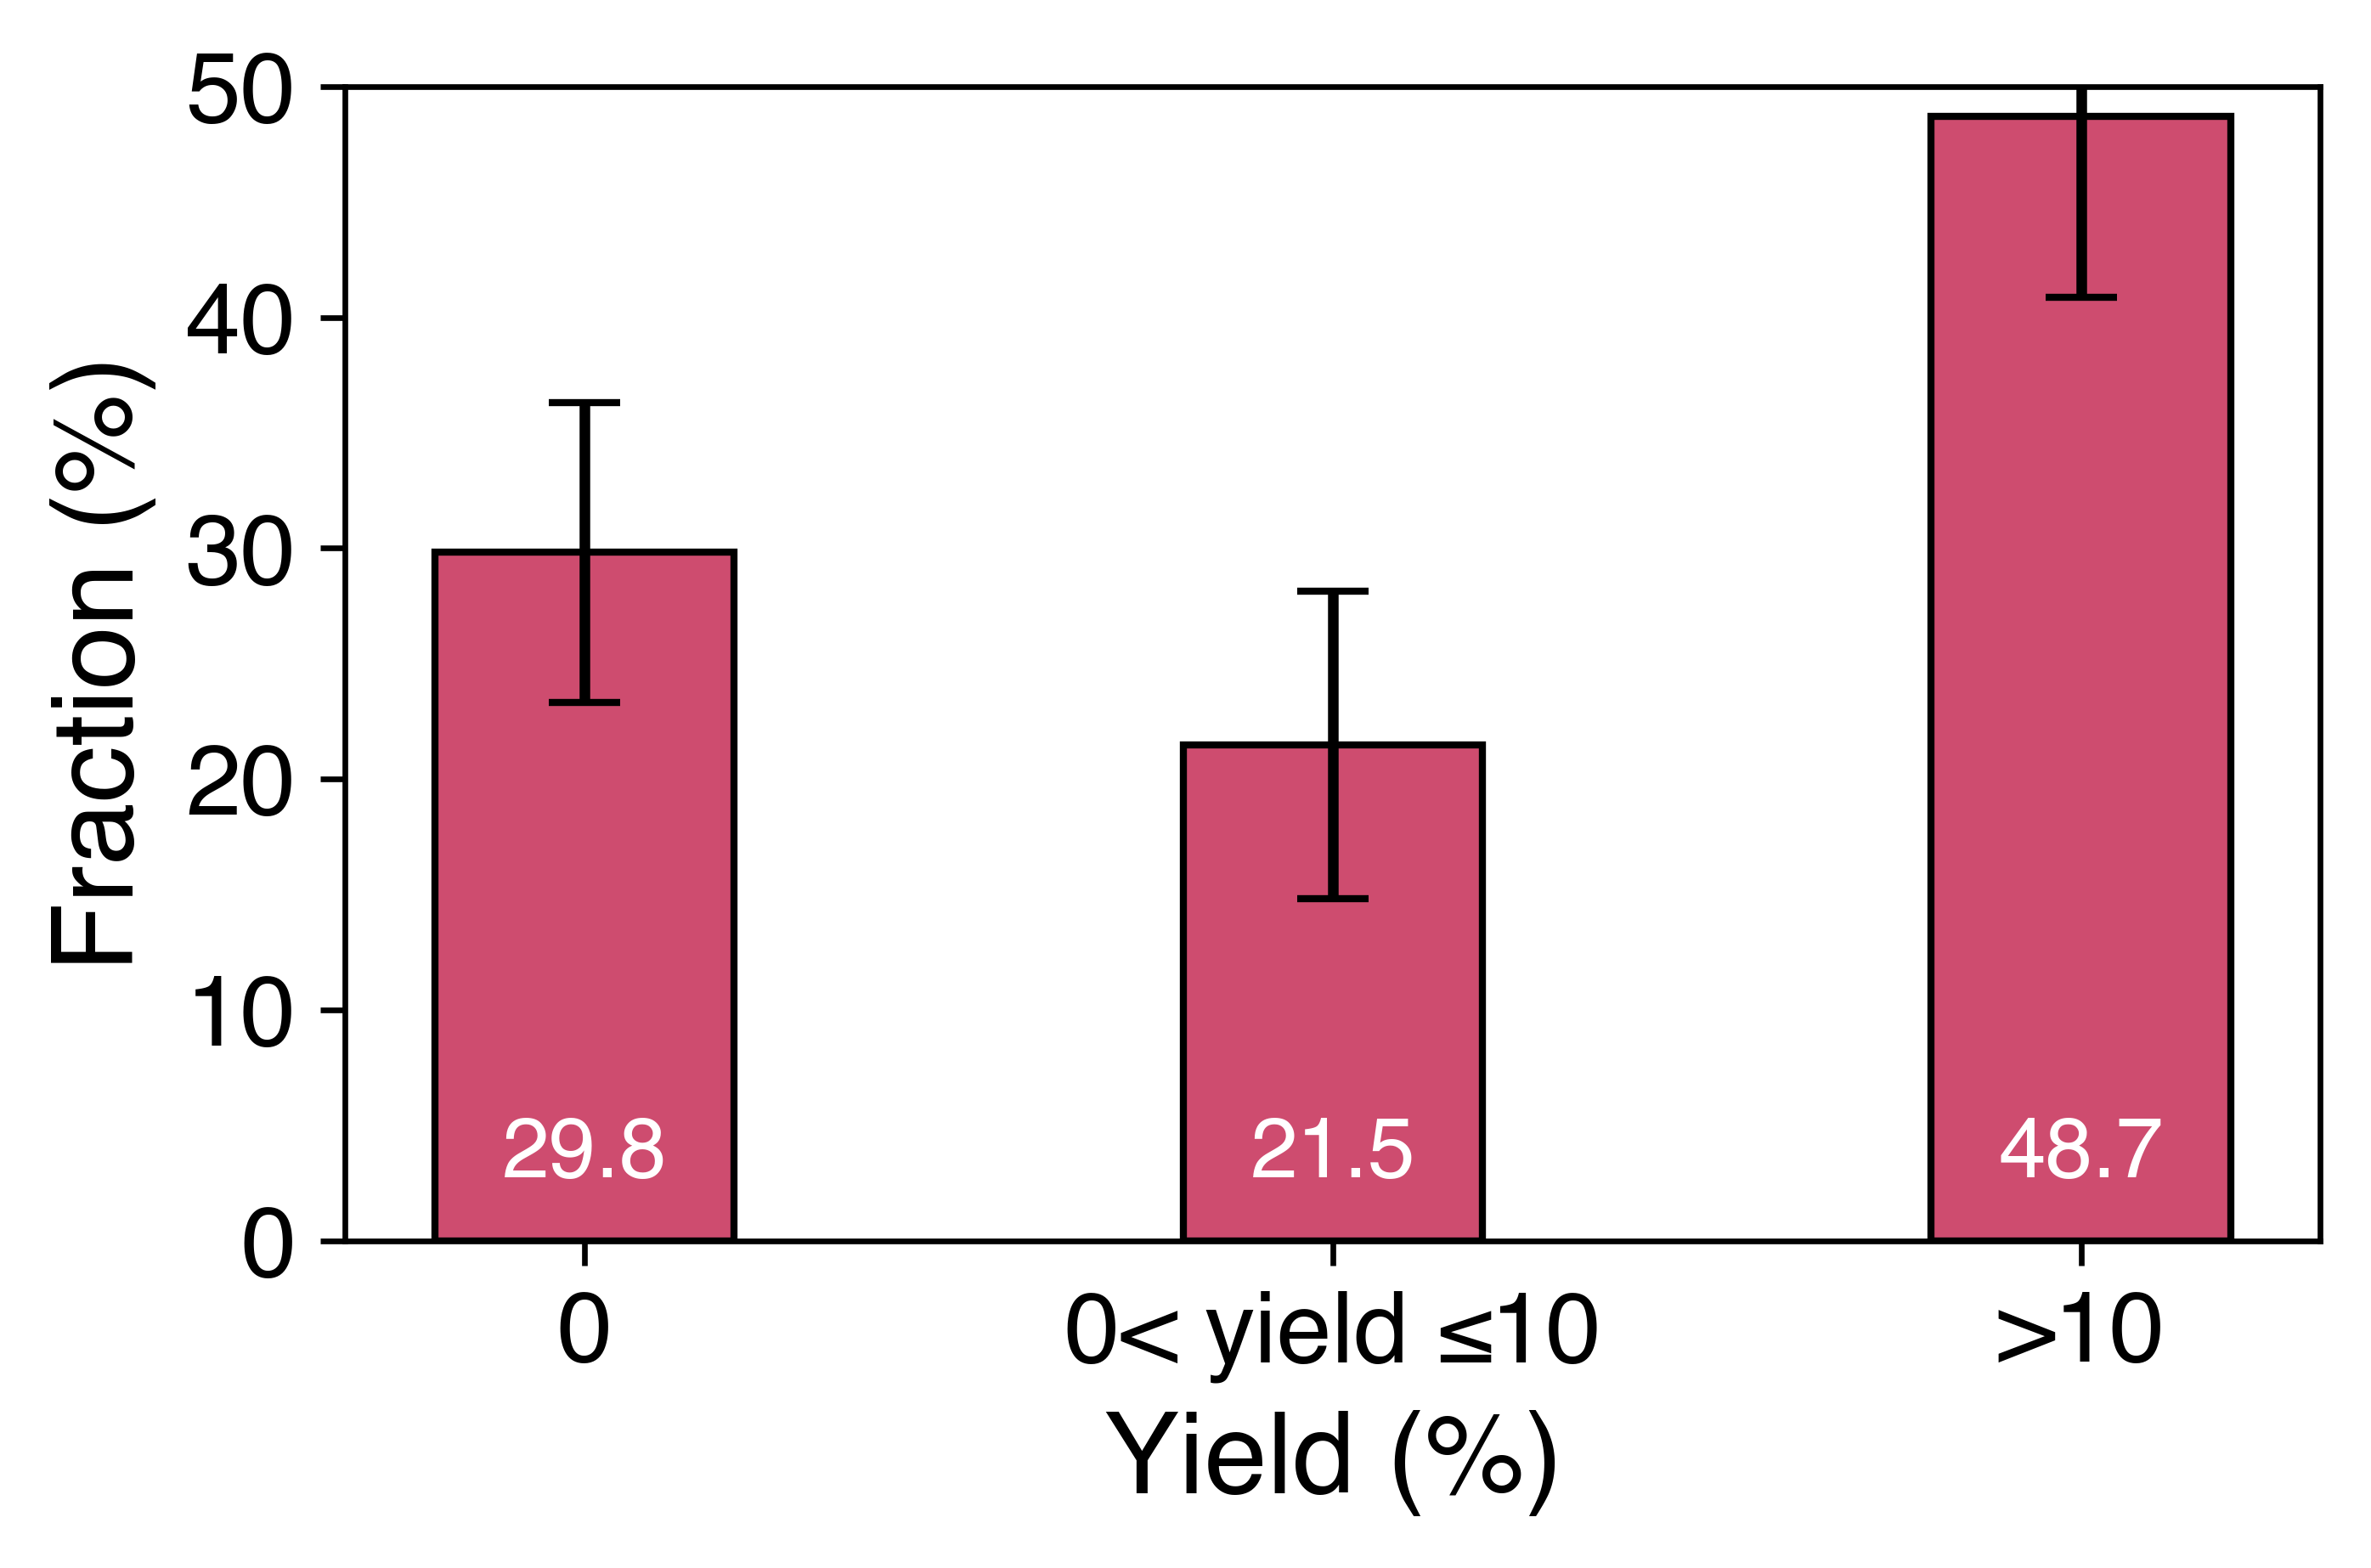

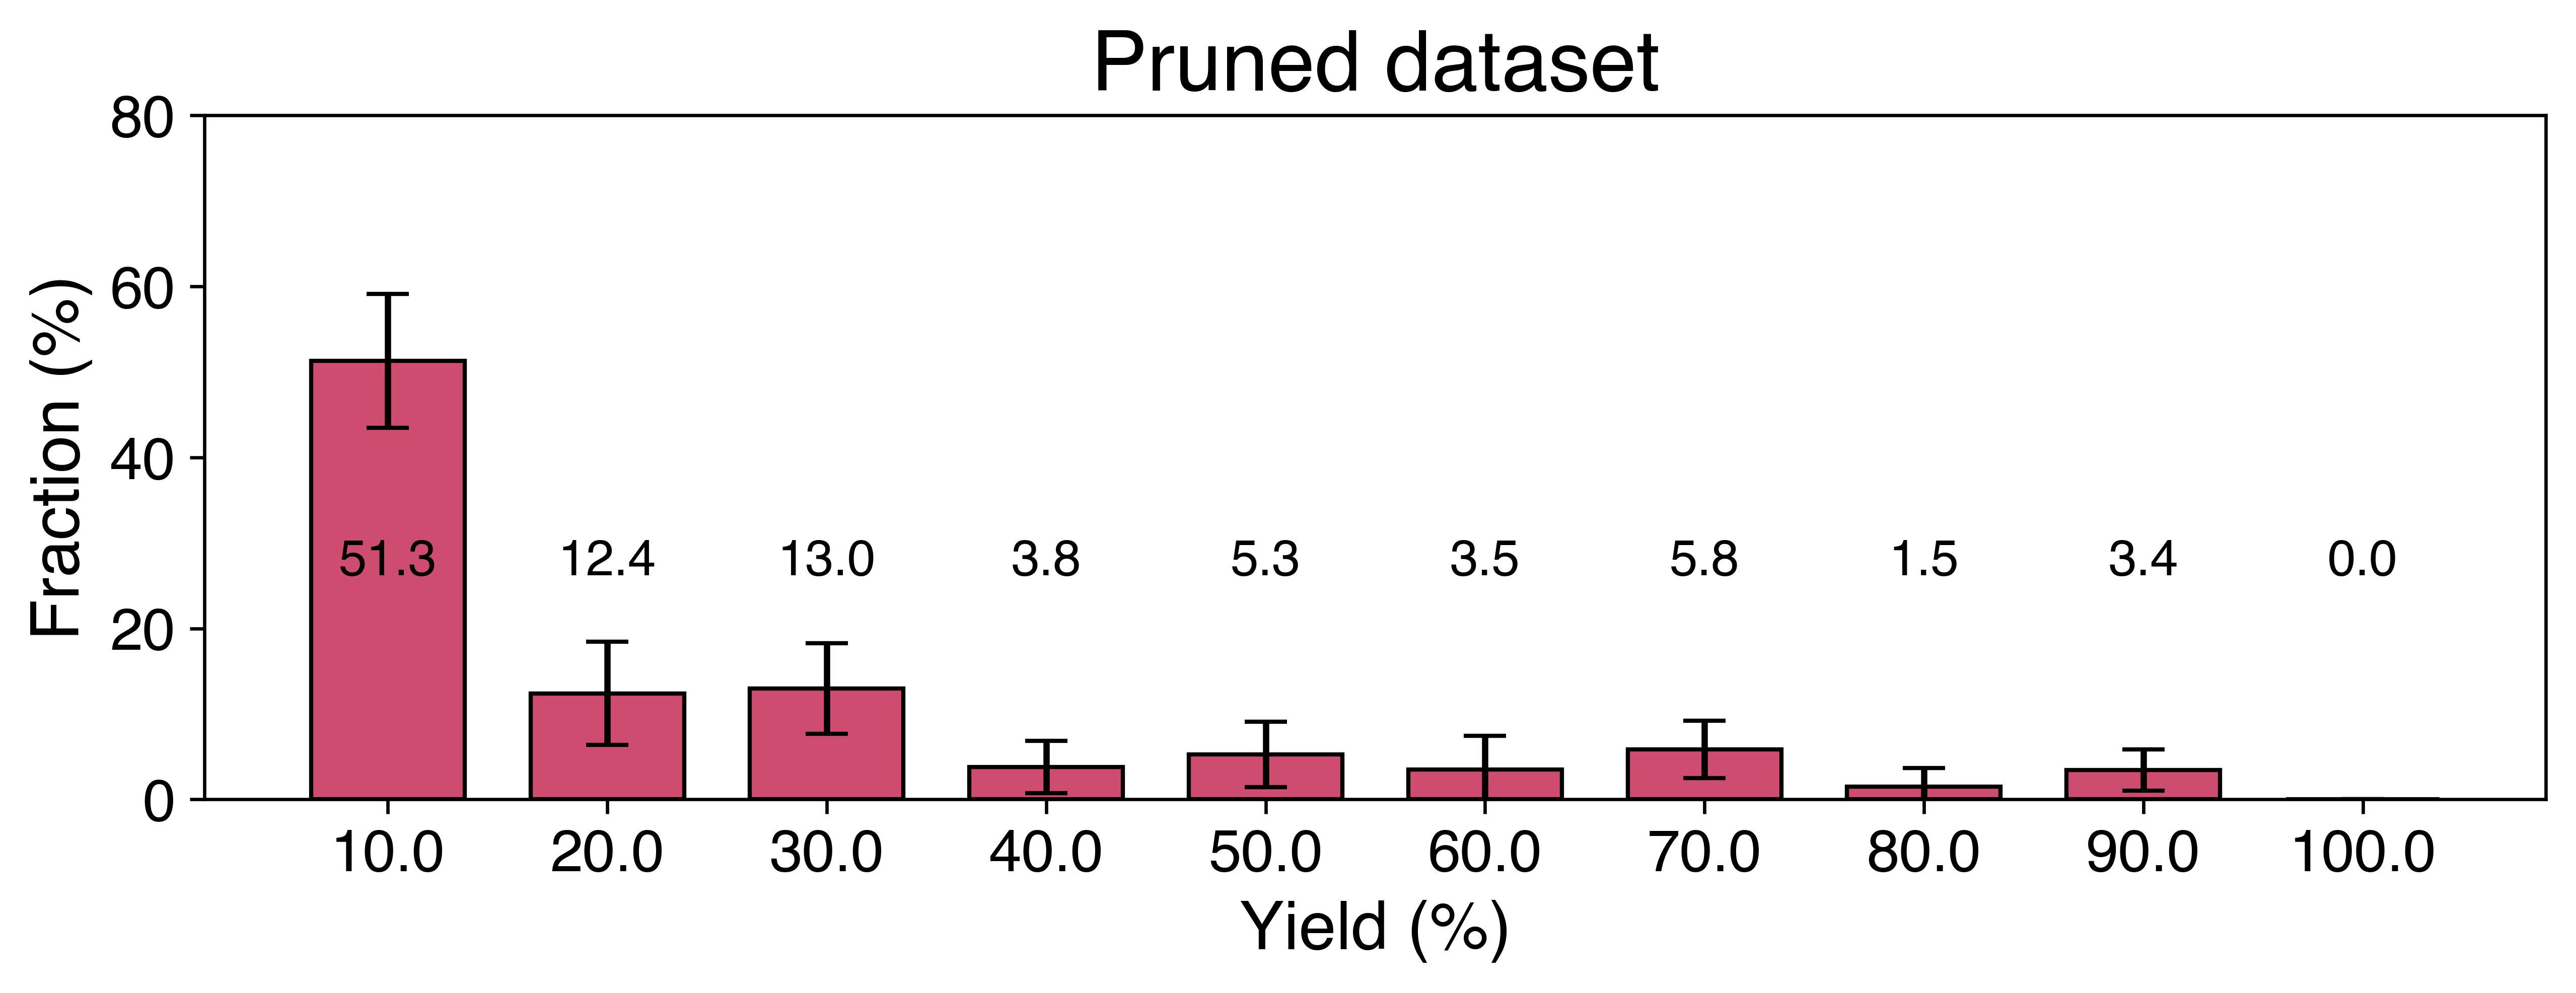

In [4]:
print("distribution of the yields for ScopeBO scopes for the pruned dataset")
df_counts_pruned = Benchmark().objective_distribution(name_results="./Results_Data/results_pruned/scope_ei_with-pruning",print_figure=False)
df_fractions_pruned = yield_cat_distribution(name_results="./Results_Data/results_pruned/scope_ei_with-pruning",norm_axis=50)
_ = yield_cat_distribution(name_results="./Results_Data/results_pruned/scope_ei_with-pruning", title = "Pruned dataset",
                           bins = np.linspace(0,100,11), labels = np.linspace(0,100,11)[1:], norm_axis=80,
                           figwidth = 10, barwidth = 0.7, text_height = 25, text_col = "k")


Compare the distributions

Comparison of the number of selected examples with standard deviation shown


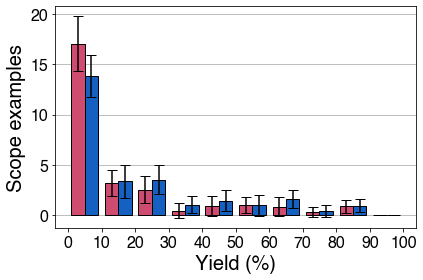

In [5]:
bin_centers = df_counts_original.columns.astype(float)

# Compute stats
mean_original = df_counts_original.mean(axis=0)
std_original = df_counts_original.std(axis=0, ddof=1)

mean_pruned = df_counts_pruned.mean(axis=0)
std_pruned = df_counts_pruned.std(axis=0, ddof=1)

# Width of bars
bar_width = 4  # half of bin spacing (10) so bars don’t overlap

plt.figure(figsize=(6,4))

# Bars for dataset 1
plt.bar(
    bin_centers - bar_width/2,
    mean_original,
    yerr=std_original,
    capsize=5,
    alpha=1,
    width=bar_width,
    label="381 bromides",
    color=all_colors[0],
    edgecolor="black", zorder = 3
)

# Bars for dataset 2
plt.bar(
    bin_centers + bar_width/2,
    mean_pruned,
    yerr=std_pruned,
    capsize=5,
    alpha=1,
    width=bar_width,
    label="269 bromides",
    color=all_colors[1],
    edgecolor="black", zorder =2
)

plt.xlabel("Yield (%)", fontsize=20)
plt.ylabel("Scope examples",fontsize = 20)
plt.xticks(np.arange(0, 110, 10),fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis="y", zorder = 1)
plt.tight_layout()
print("Comparison of the number of selected examples with standard deviation shown")
plt.show()


Same comparison, but with a focus on low performers

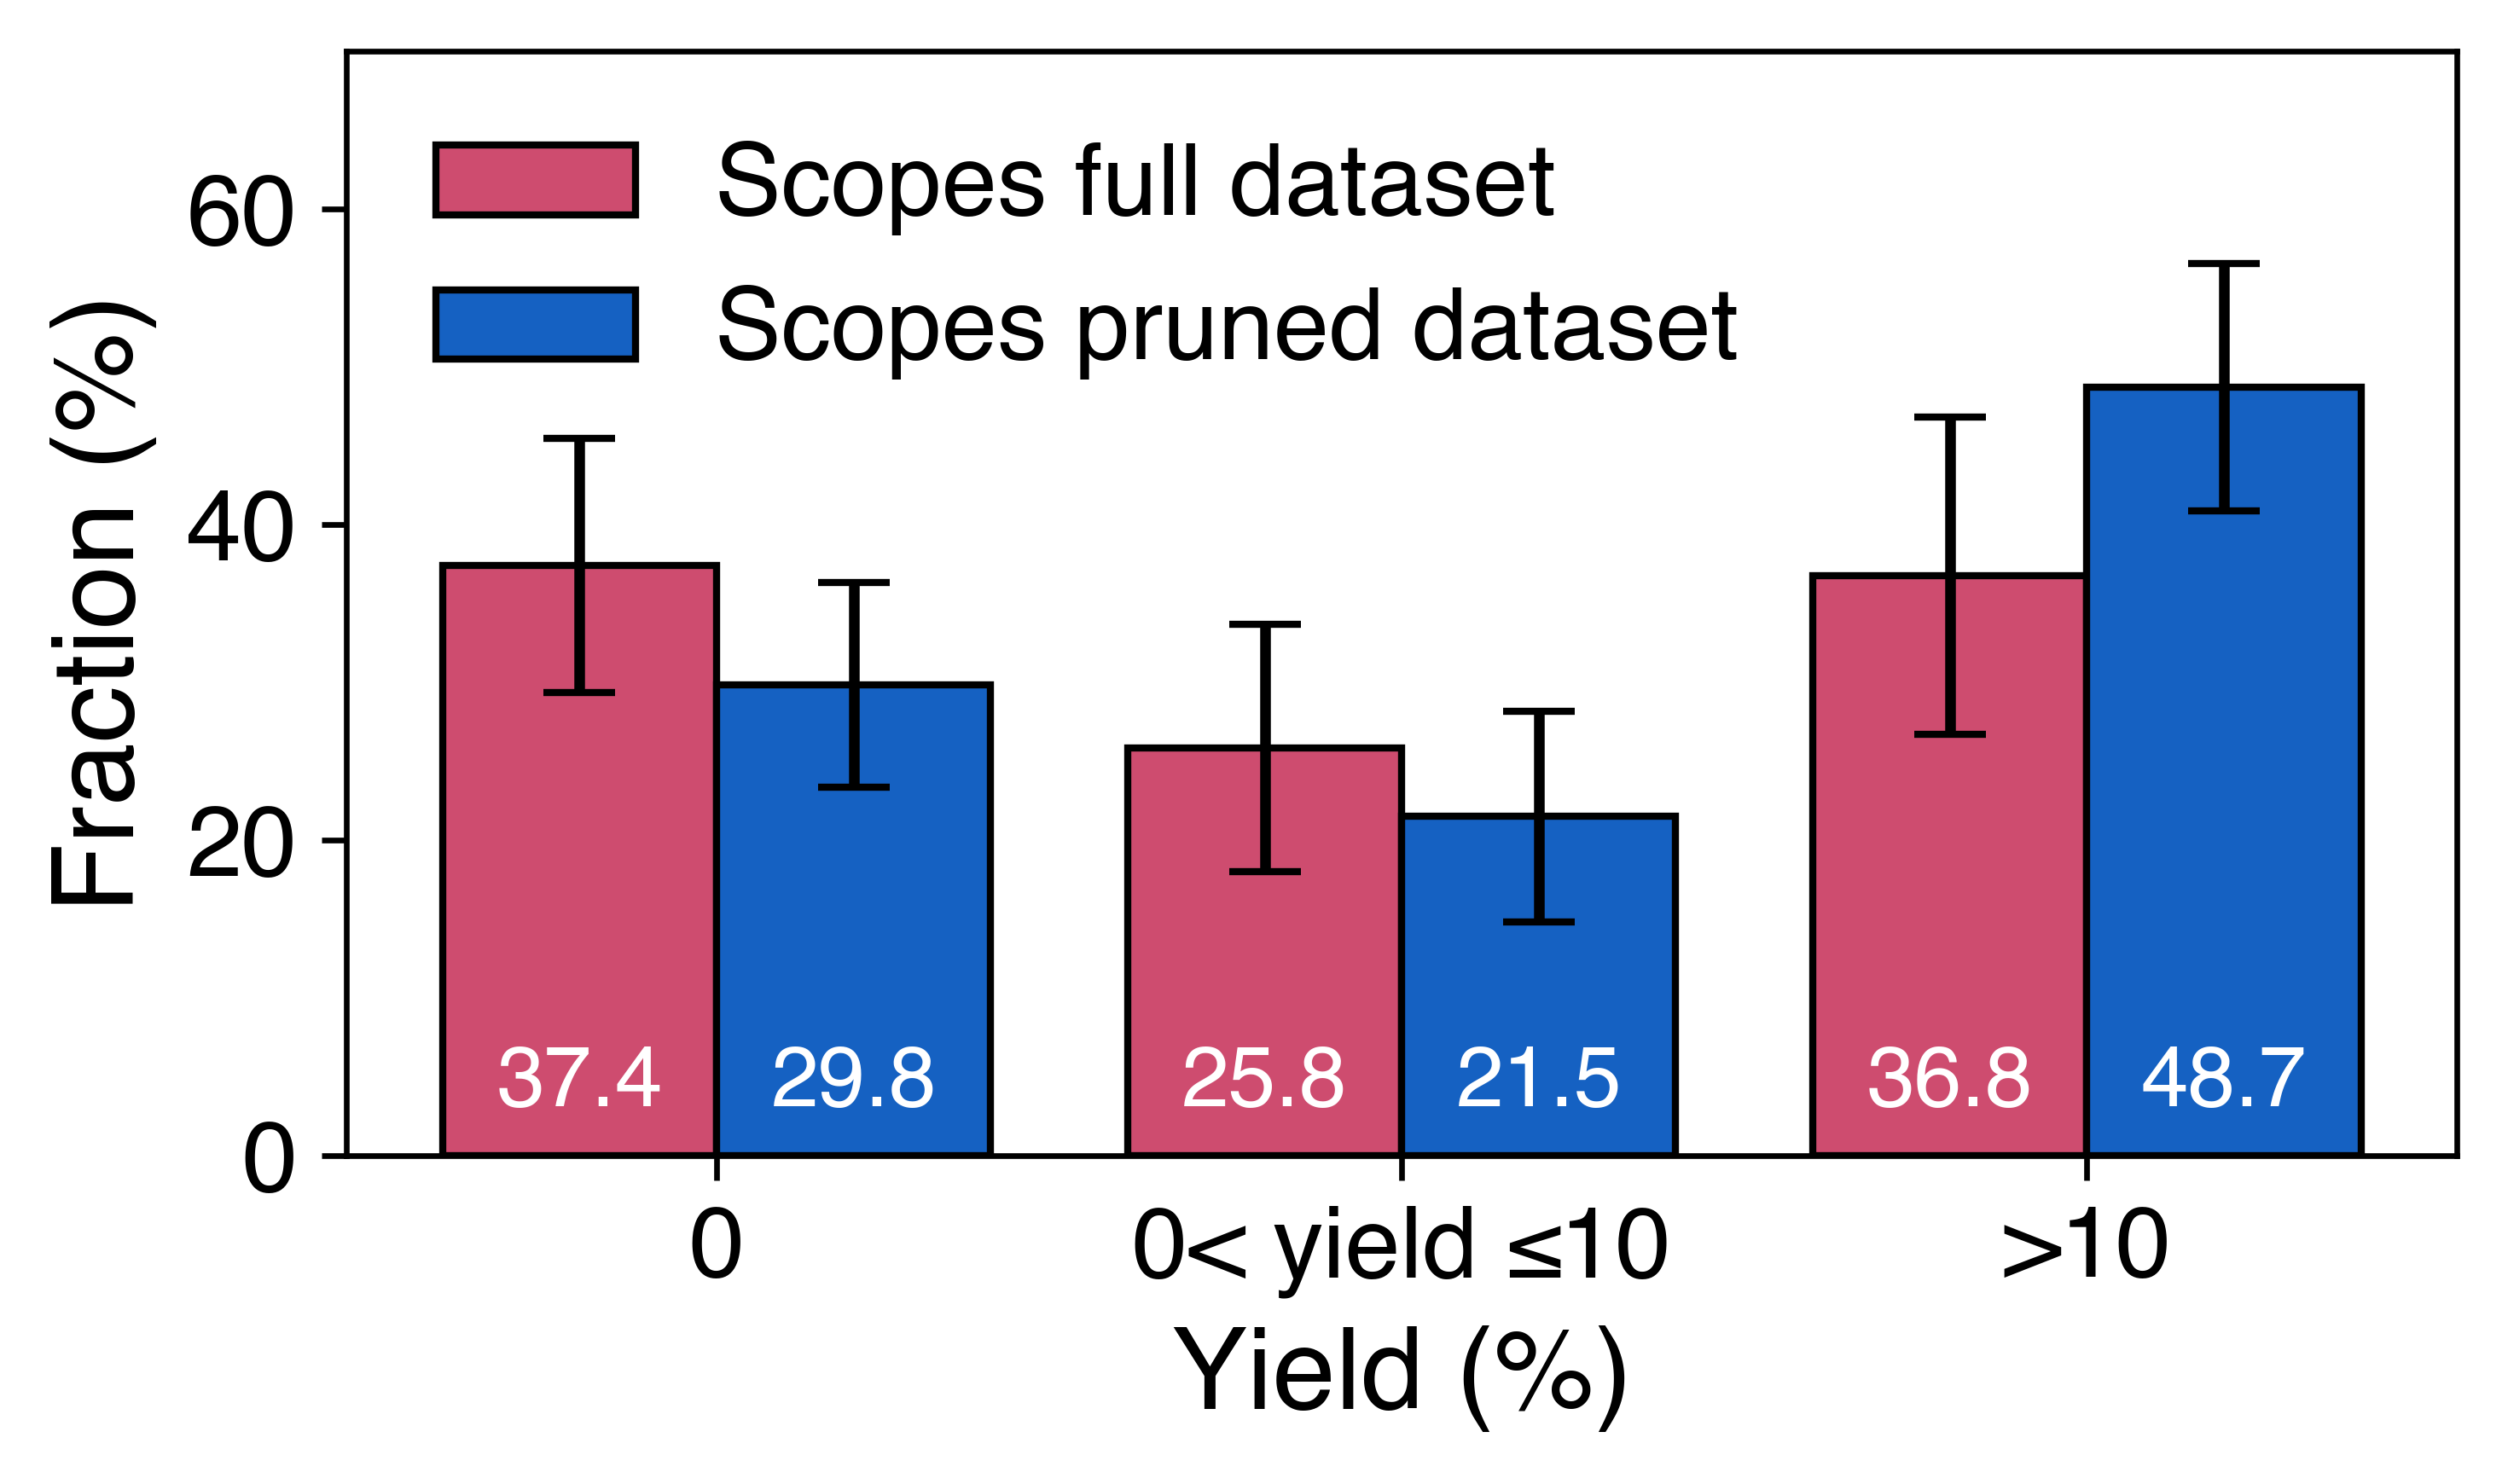

In [6]:
# Set up positions for grouped bars
x = np.arange(len(df_fractions_original.columns))
width = 0.4  # width of the bars
means_original = df_fractions_original.mean()
stdevs_original = df_fractions_original.std(ddof=1)
means_pruned = df_fractions_pruned.mean()
stdevs_pruned = df_fractions_pruned.std(ddof=1)

plt.figure(figsize=(5, 3), dpi=600)
plt.bar(x - width/2, means_original, width, yerr=stdevs_original, capsize = 5, label = 'Scopes full dataset', color=all_colors[0], edgecolor='k')
plt.bar(x + width/2, means_pruned, width, yerr=stdevs_pruned, capsize = 5, label='Scopes pruned dataset', color=all_colors[1], edgecolor='k')
plt.xticks(x, df_fractions_original.columns)
plt.ylabel('Fraction (%)')
plt.ylim(0,70)
plt.xlabel('Yield (%)')
plt.legend(frameon=False)

# Add values
for i, v in enumerate(means_original):
    plt.text(x[i] - width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12, c ="white")
for i, v in enumerate(means_pruned):
    plt.text(x[i] + width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12,c="white")

plt.tight_layout()
plt.show()

Compare the distributions of the selected scopes and the distribution in the corresponding dataset

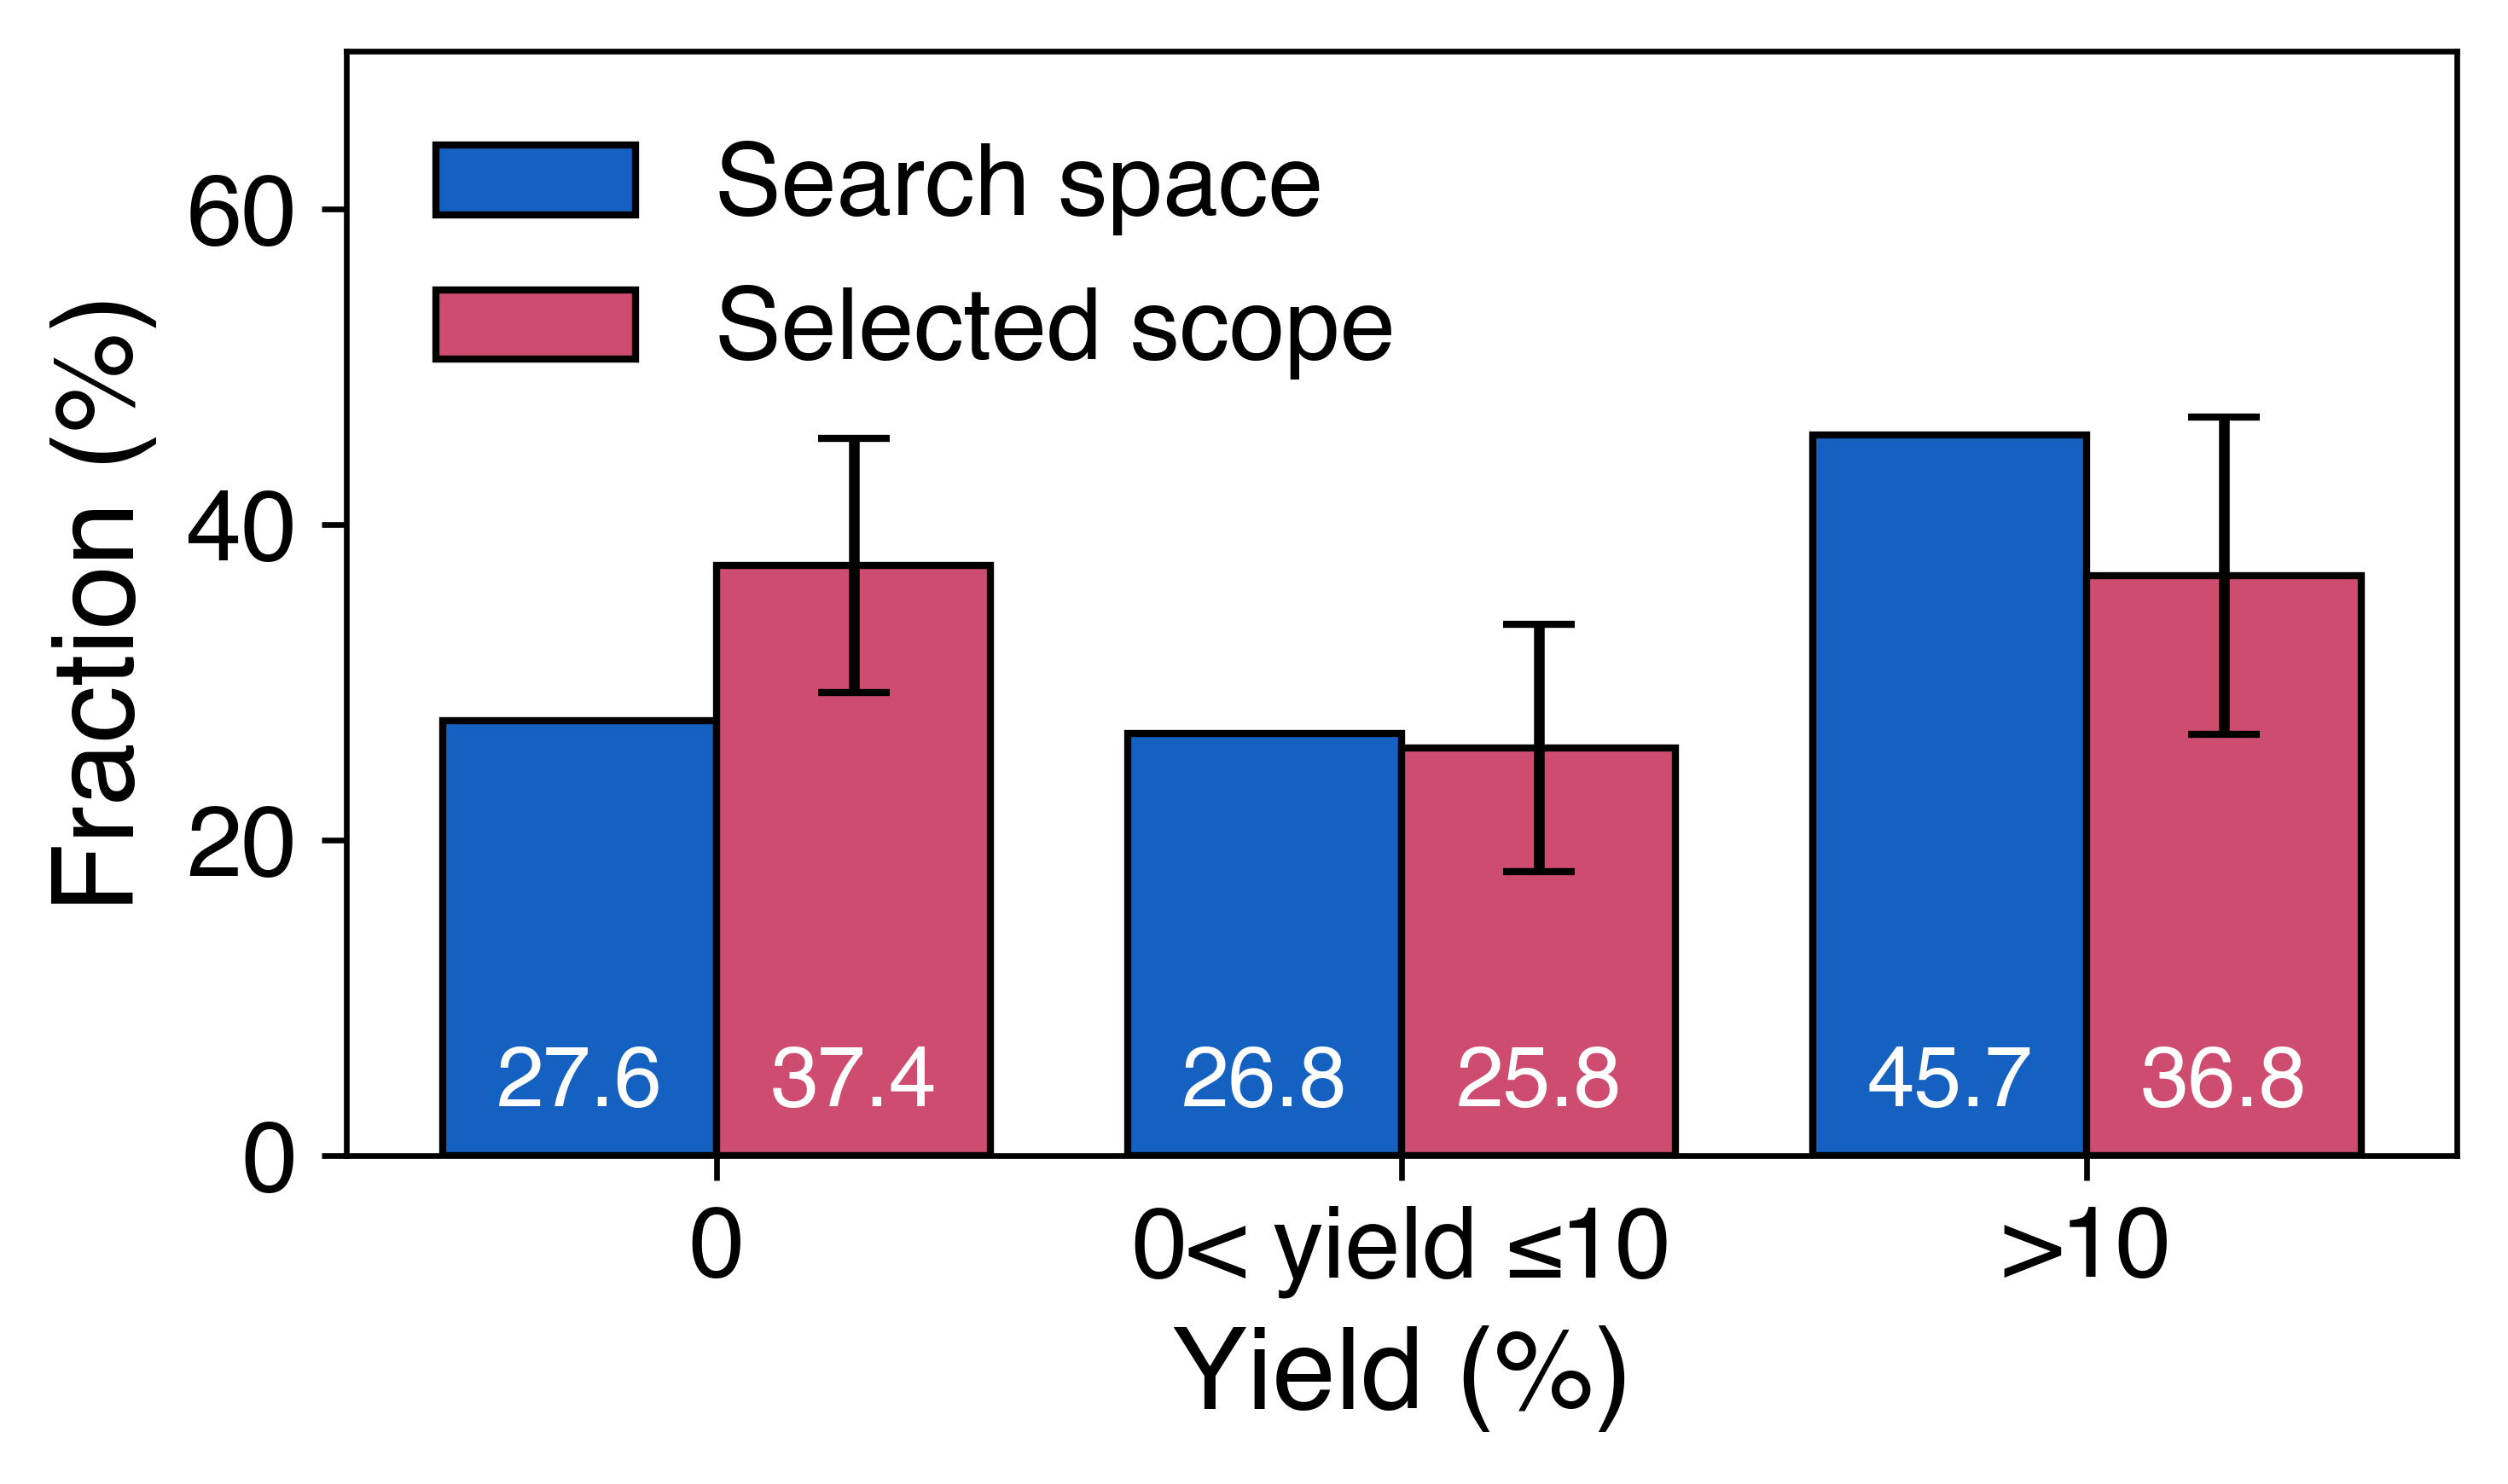

In [7]:
# load the labelled original scope
df_labelled_original = pd.read_csv(f"./../XEC_data/Datasets/xec_dft_data_bromide_scope.csv",index_col=0, header=0)

# load the labelled pruned scope
df_labelled_pruned = pd.read_csv(f"./../XEC_data/Datasets/xec_dft_data_bromide_scope_pruned.csv",index_col=0, header=0)

# Define bins and labels
bins = [-1000, 0, 10, 1000]
labels = ['0', '0< yield ≤10', '>10']

# Cut into bins
df_labelled_pruned['bin'] = pd.cut(df_labelled_pruned['yield'], bins=bins, labels=labels, right=True)
df_labelled_original['bin'] = pd.cut(df_labelled_original['yield'], bins=bins, labels=labels, right=True)

# Compute normalized percentages for each bin
counts_data = df_labelled_original['bin'].value_counts(normalize=True).sort_index() * 100
counts_pruned = df_labelled_pruned['bin'].value_counts(normalize=True).sort_index() * 100

# Ensure both series align by index (in case one is missing a category)
all_bins = sorted(set(counts_data.index) | set(counts_pruned.index))
counts_data = counts_data.reindex(all_bins, fill_value=0)
counts_pruned = counts_pruned.reindex(all_bins, fill_value=0)

# Set up positions for grouped bars
x = np.arange(len(all_bins))
width = 0.4  # width of the bars

plt.figure(figsize=(5, 3), dpi=600)
plt.bar(x - width/2, counts_data, width, label='Search space', color=all_colors[1], edgecolor='k')
plt.bar(x + width/2, means_original, width, yerr=stdevs_original, capsize = 5, label = 'Selected scope', color=all_colors[0], edgecolor='k')
plt.xticks(x, all_bins)
plt.ylabel('Fraction (%)')
plt.ylim(0,70)
plt.xlabel('Yield (%)')
plt.legend(frameon=False)

# Add values
for i, v in enumerate(counts_data):
    plt.text(x[i] - width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12, c ="white")
for i, v in enumerate(means_original):
    plt.text(x[i] + width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12,c="white")

plt.tight_layout()
plt.show()


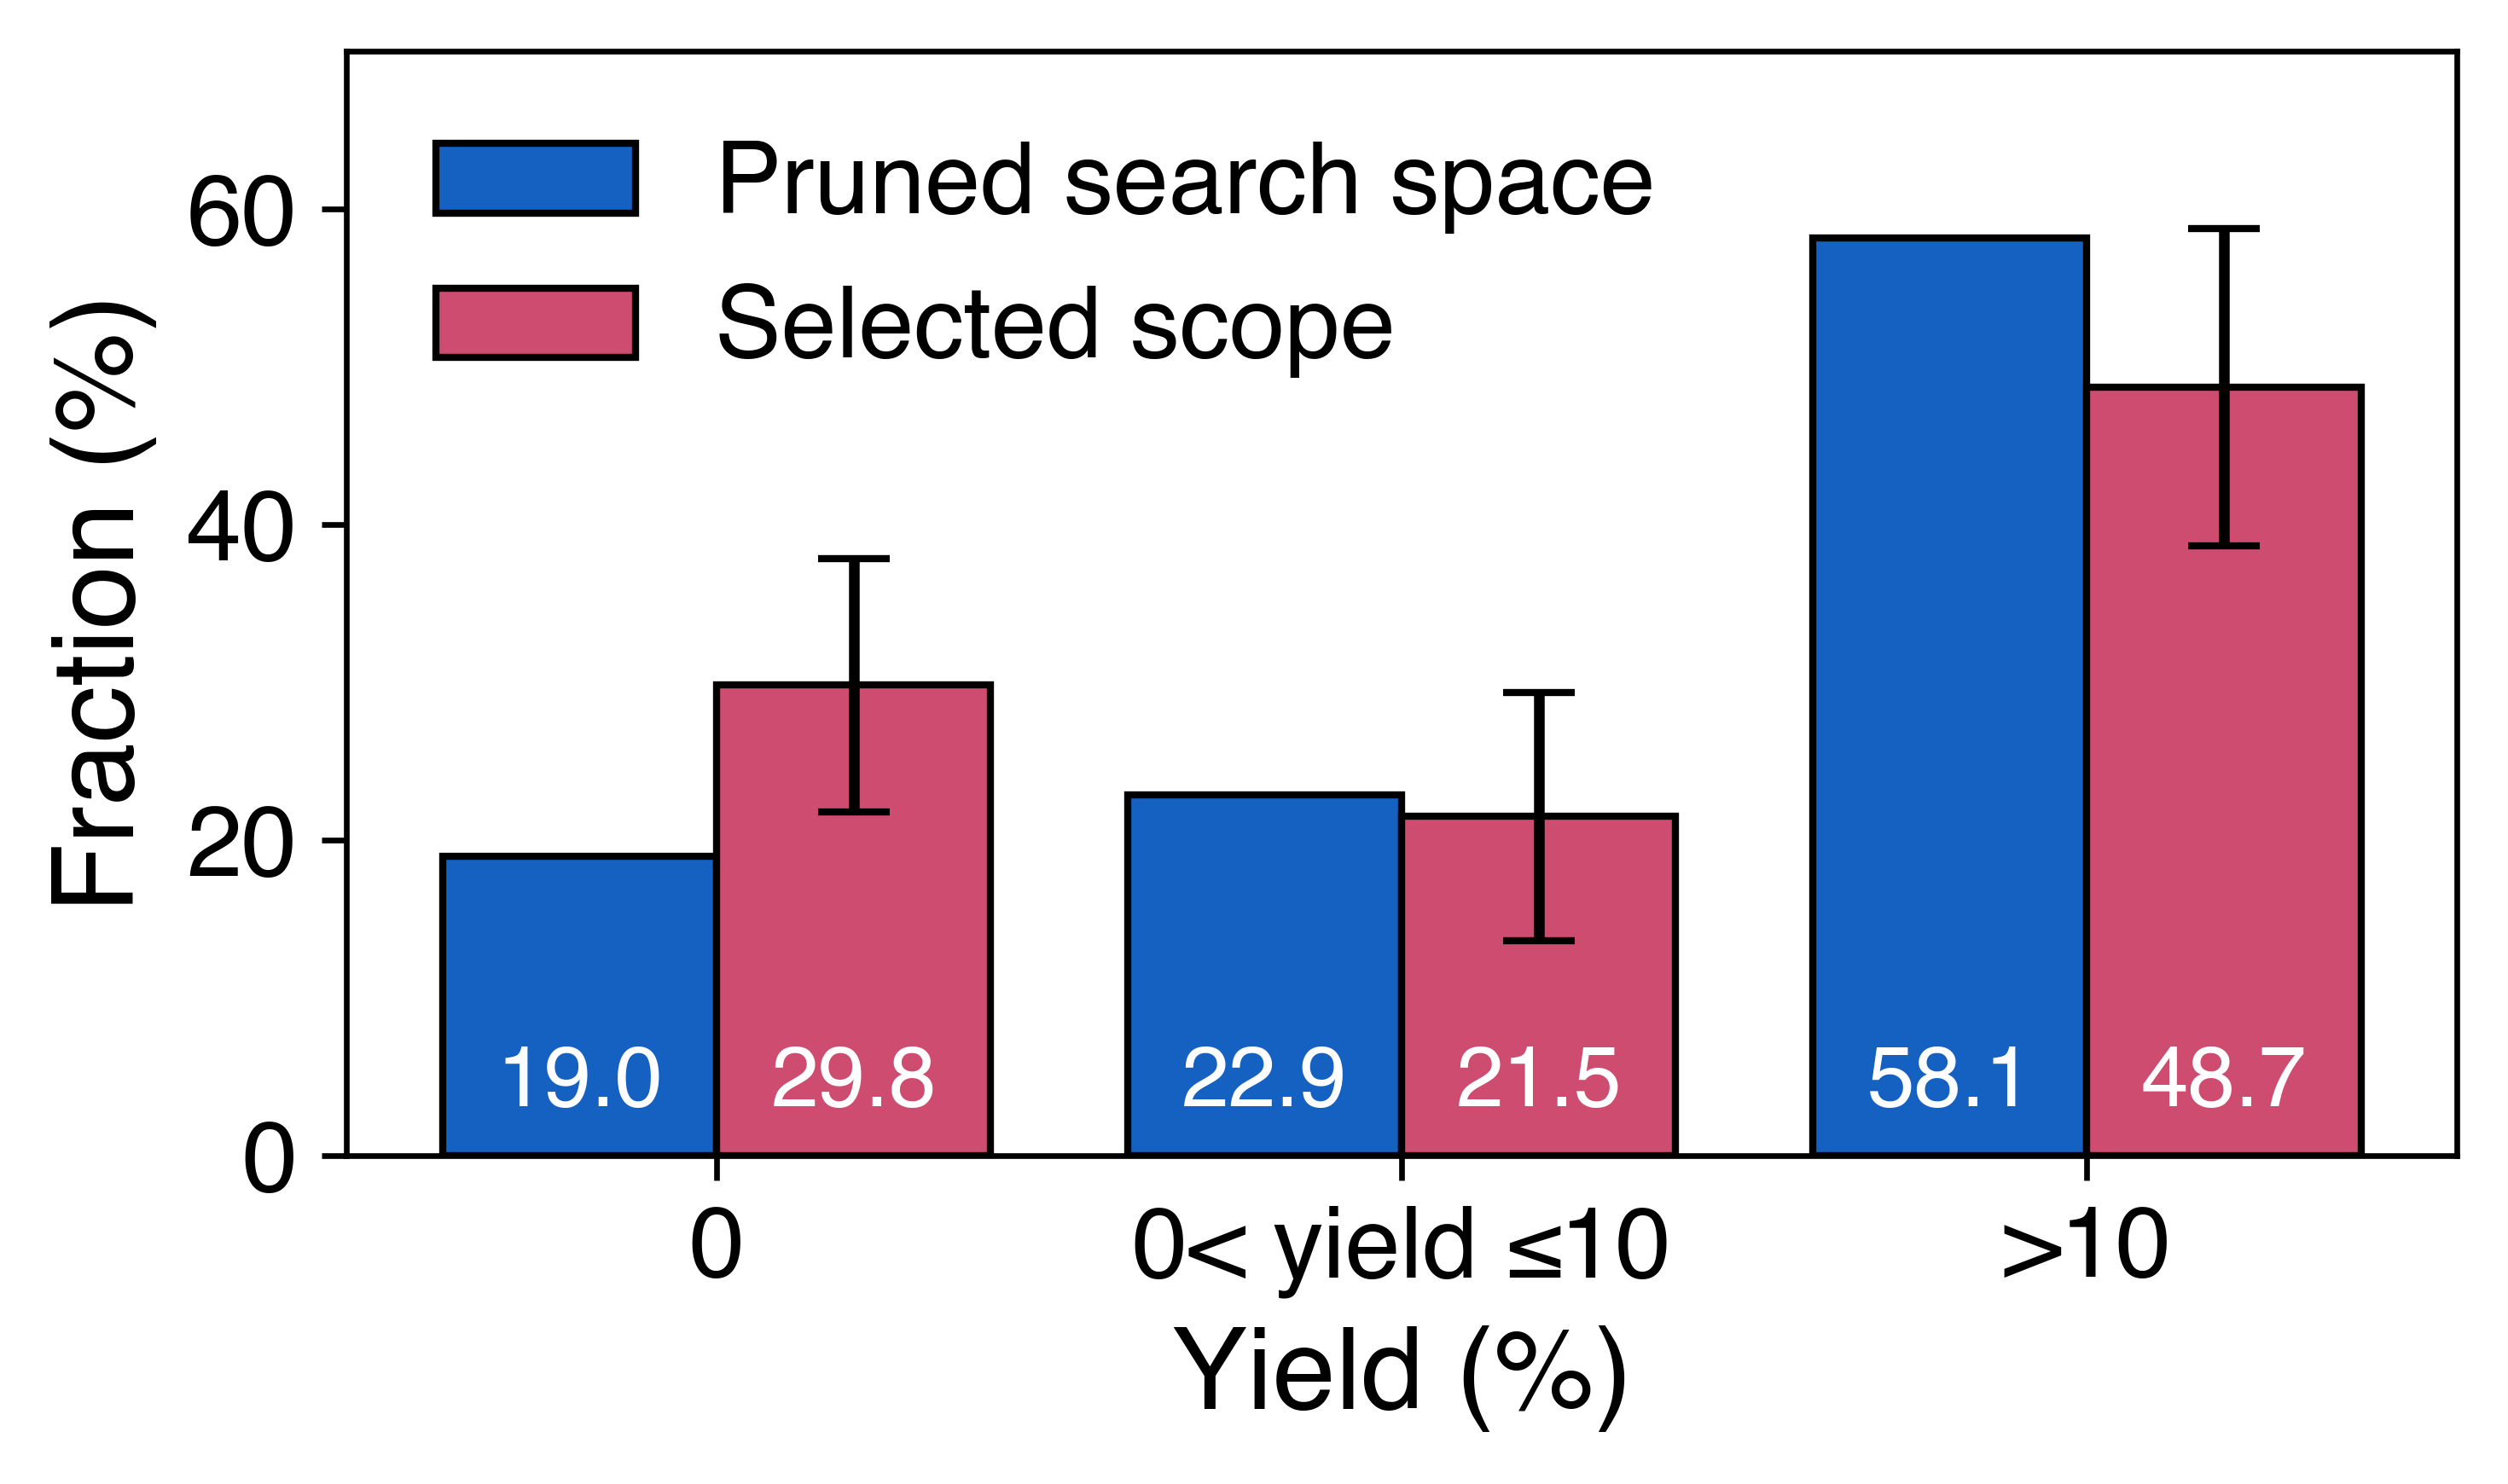

In [8]:
plt.figure(figsize=(5, 3), dpi=600)
plt.bar(x - width/2, counts_pruned, width, label='Pruned search space', color=all_colors[1], edgecolor='k')
plt.bar(x + width/2, means_pruned, width, yerr=stdevs_original, capsize = 5, label = 'Selected scope', color=all_colors[0], edgecolor='k')
plt.xticks(x, all_bins)
plt.ylabel('Fraction (%)')
plt.ylim(0,70)
plt.xlabel('Yield (%)')
plt.legend(frameon=False)

# Add values
for i, v in enumerate(counts_pruned):
    plt.text(x[i] - width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12, c ="white")
for i, v in enumerate(means_pruned):
    plt.text(x[i] + width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12,c="white")

plt.tight_layout()
plt.show()

Print as a combined figure for both datasets and also highlight the samples that were removed from the unpruned dataset going to the pruned one

In [9]:
# calculate the fraction of samples that were removed in the pruning step for each of the yield categories
counts_remaining = counts_pruned * 258 / 381
counts_removed = counts_data - counts_remaining

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


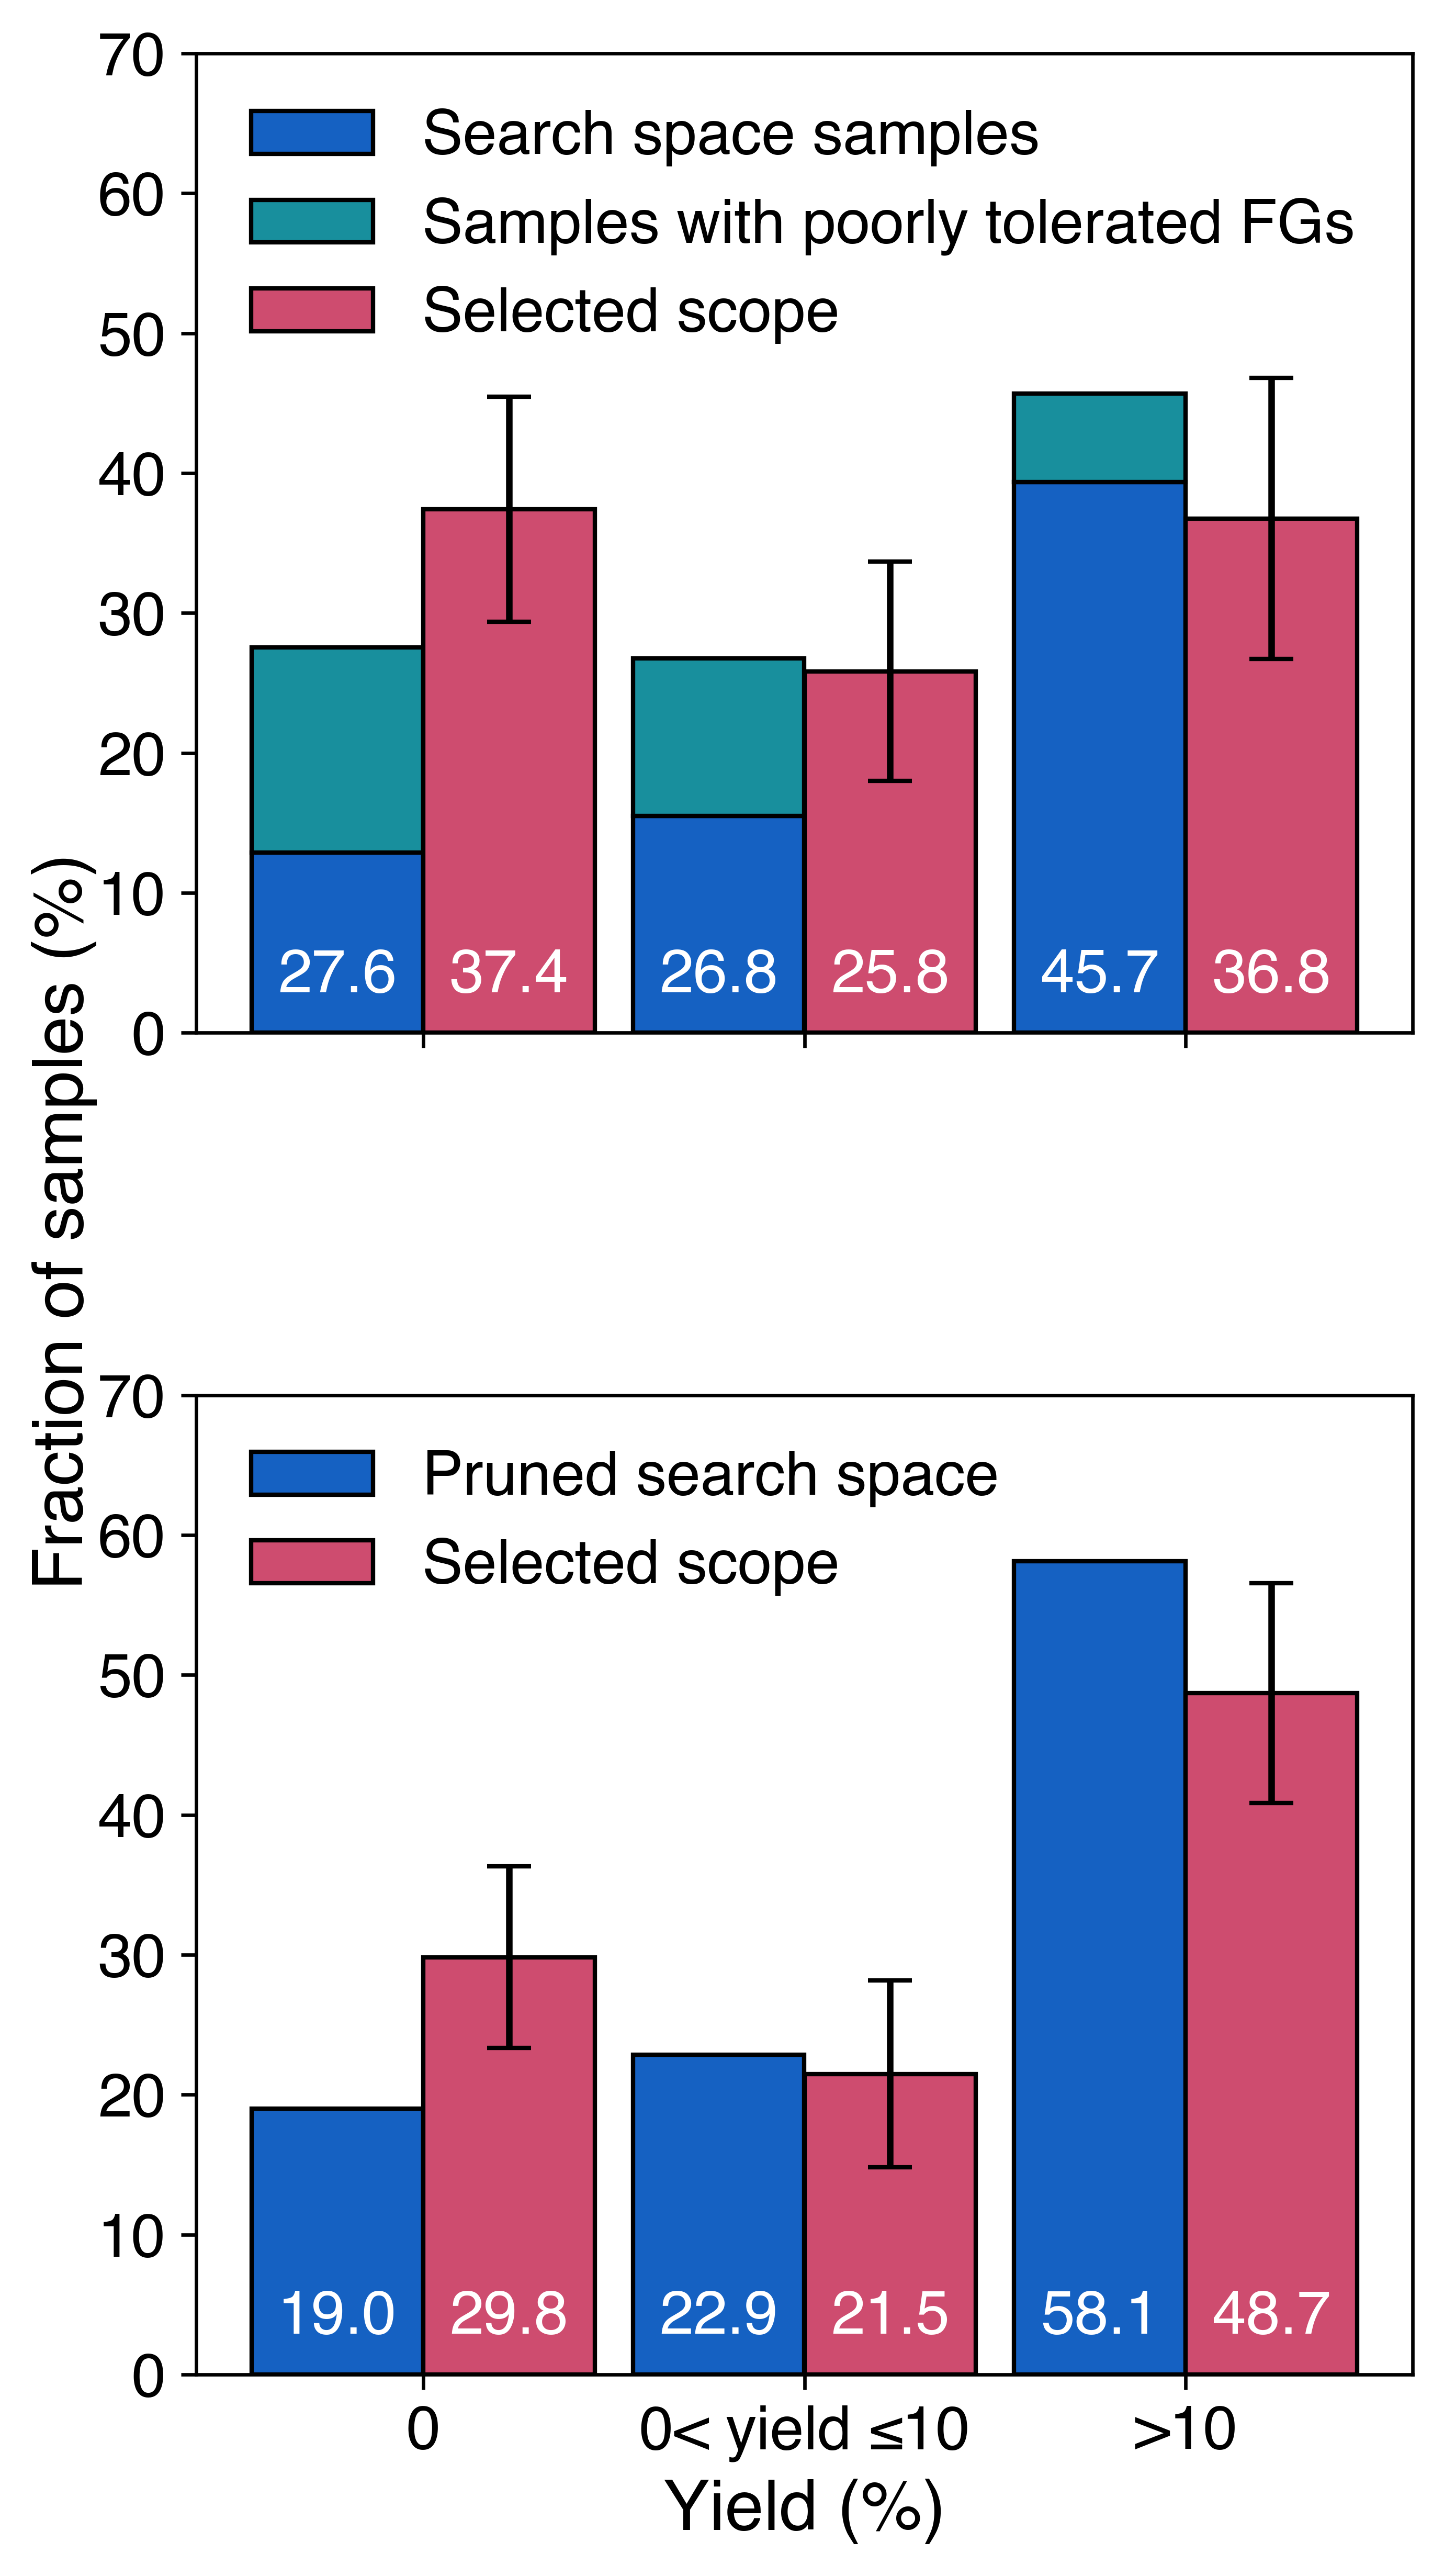

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(5, 9.79), dpi=600, sharex=True, sharey=True, gridspec_kw={"hspace": 0.37})
fig.supylabel("Fraction of samples (%)",fontsize = 16)

width = 0.45

bar1 = axs[0].bar(x - width/2, counts_remaining, width, label='Search space samples',
        color=all_colors[1], edgecolor='k')
bar2 = axs[0].bar(x - width/2, counts_removed, bottom = counts_remaining, width = width, label='Samples with poorly tolerated FGs',
        color=all_colors[2], edgecolor='k')
bar3= axs[0].bar(x + width/2, means_original, width, yerr=stdevs_original,
        capsize=5, label='Selected scope',
        color=all_colors[0], edgecolor='k')
axs[1].bar(x - width/2, counts_pruned, width, label='Pruned search space',
        color=all_colors[1], edgecolor='k')
axs[1].bar(x + width/2, means_pruned, width, yerr=stdevs_pruned,
        capsize=5, label='Selected scope',
        color=all_colors[0], edgecolor='k')

for data_counter,ax in enumerate(axs):
    ax.set_xticks(x)
    ax.set_xticklabels(all_bins)
    ax.set_ylim(0, 70)
    ax.legend(frameon=False,loc="upper left")

    counts = counts_data
    means = means_original
    if data_counter == 1:
        counts = counts_pruned
        means = means_pruned

    for i, v in enumerate(counts):
        ax.text(x[i] - width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=14, c="white")
    for i, v in enumerate(means):
        ax.text(x[i] + width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=14, c="white")

axs[-1].set_xlabel('Yield (%)')

plt.tight_layout()
plt.show()


Reprint the figure with only two yield bins

In [11]:
df_fractions_original_bin = yield_cat_distribution(name_results="./Results_Data/results_unpruned/scope_ei_with-pruning", suppress_plot=True, 
                                                   bins = [-1000,10,1000], labels = ["≤10",">10"])
df_fractions_pruned_bin = yield_cat_distribution(name_results="./Results_Data/results_pruned/scope_ei_with-pruning", suppress_plot=True, 
                                                 bins = [-1000,10,1000], labels = ["≤10",">10"])


In [12]:
def adj_counts(vals):
    new_vals = [
        vals[0] + vals[1],
        vals[2]
    ]
    return new_vals

In [13]:
means_original_bin = df_fractions_original_bin.mean()
stdevs_original_bin = df_fractions_original_bin.std(ddof=1)
means_pruned_bin = df_fractions_pruned_bin.mean()
stdevs_pruned_bin = df_fractions_pruned_bin.std(ddof=1)

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


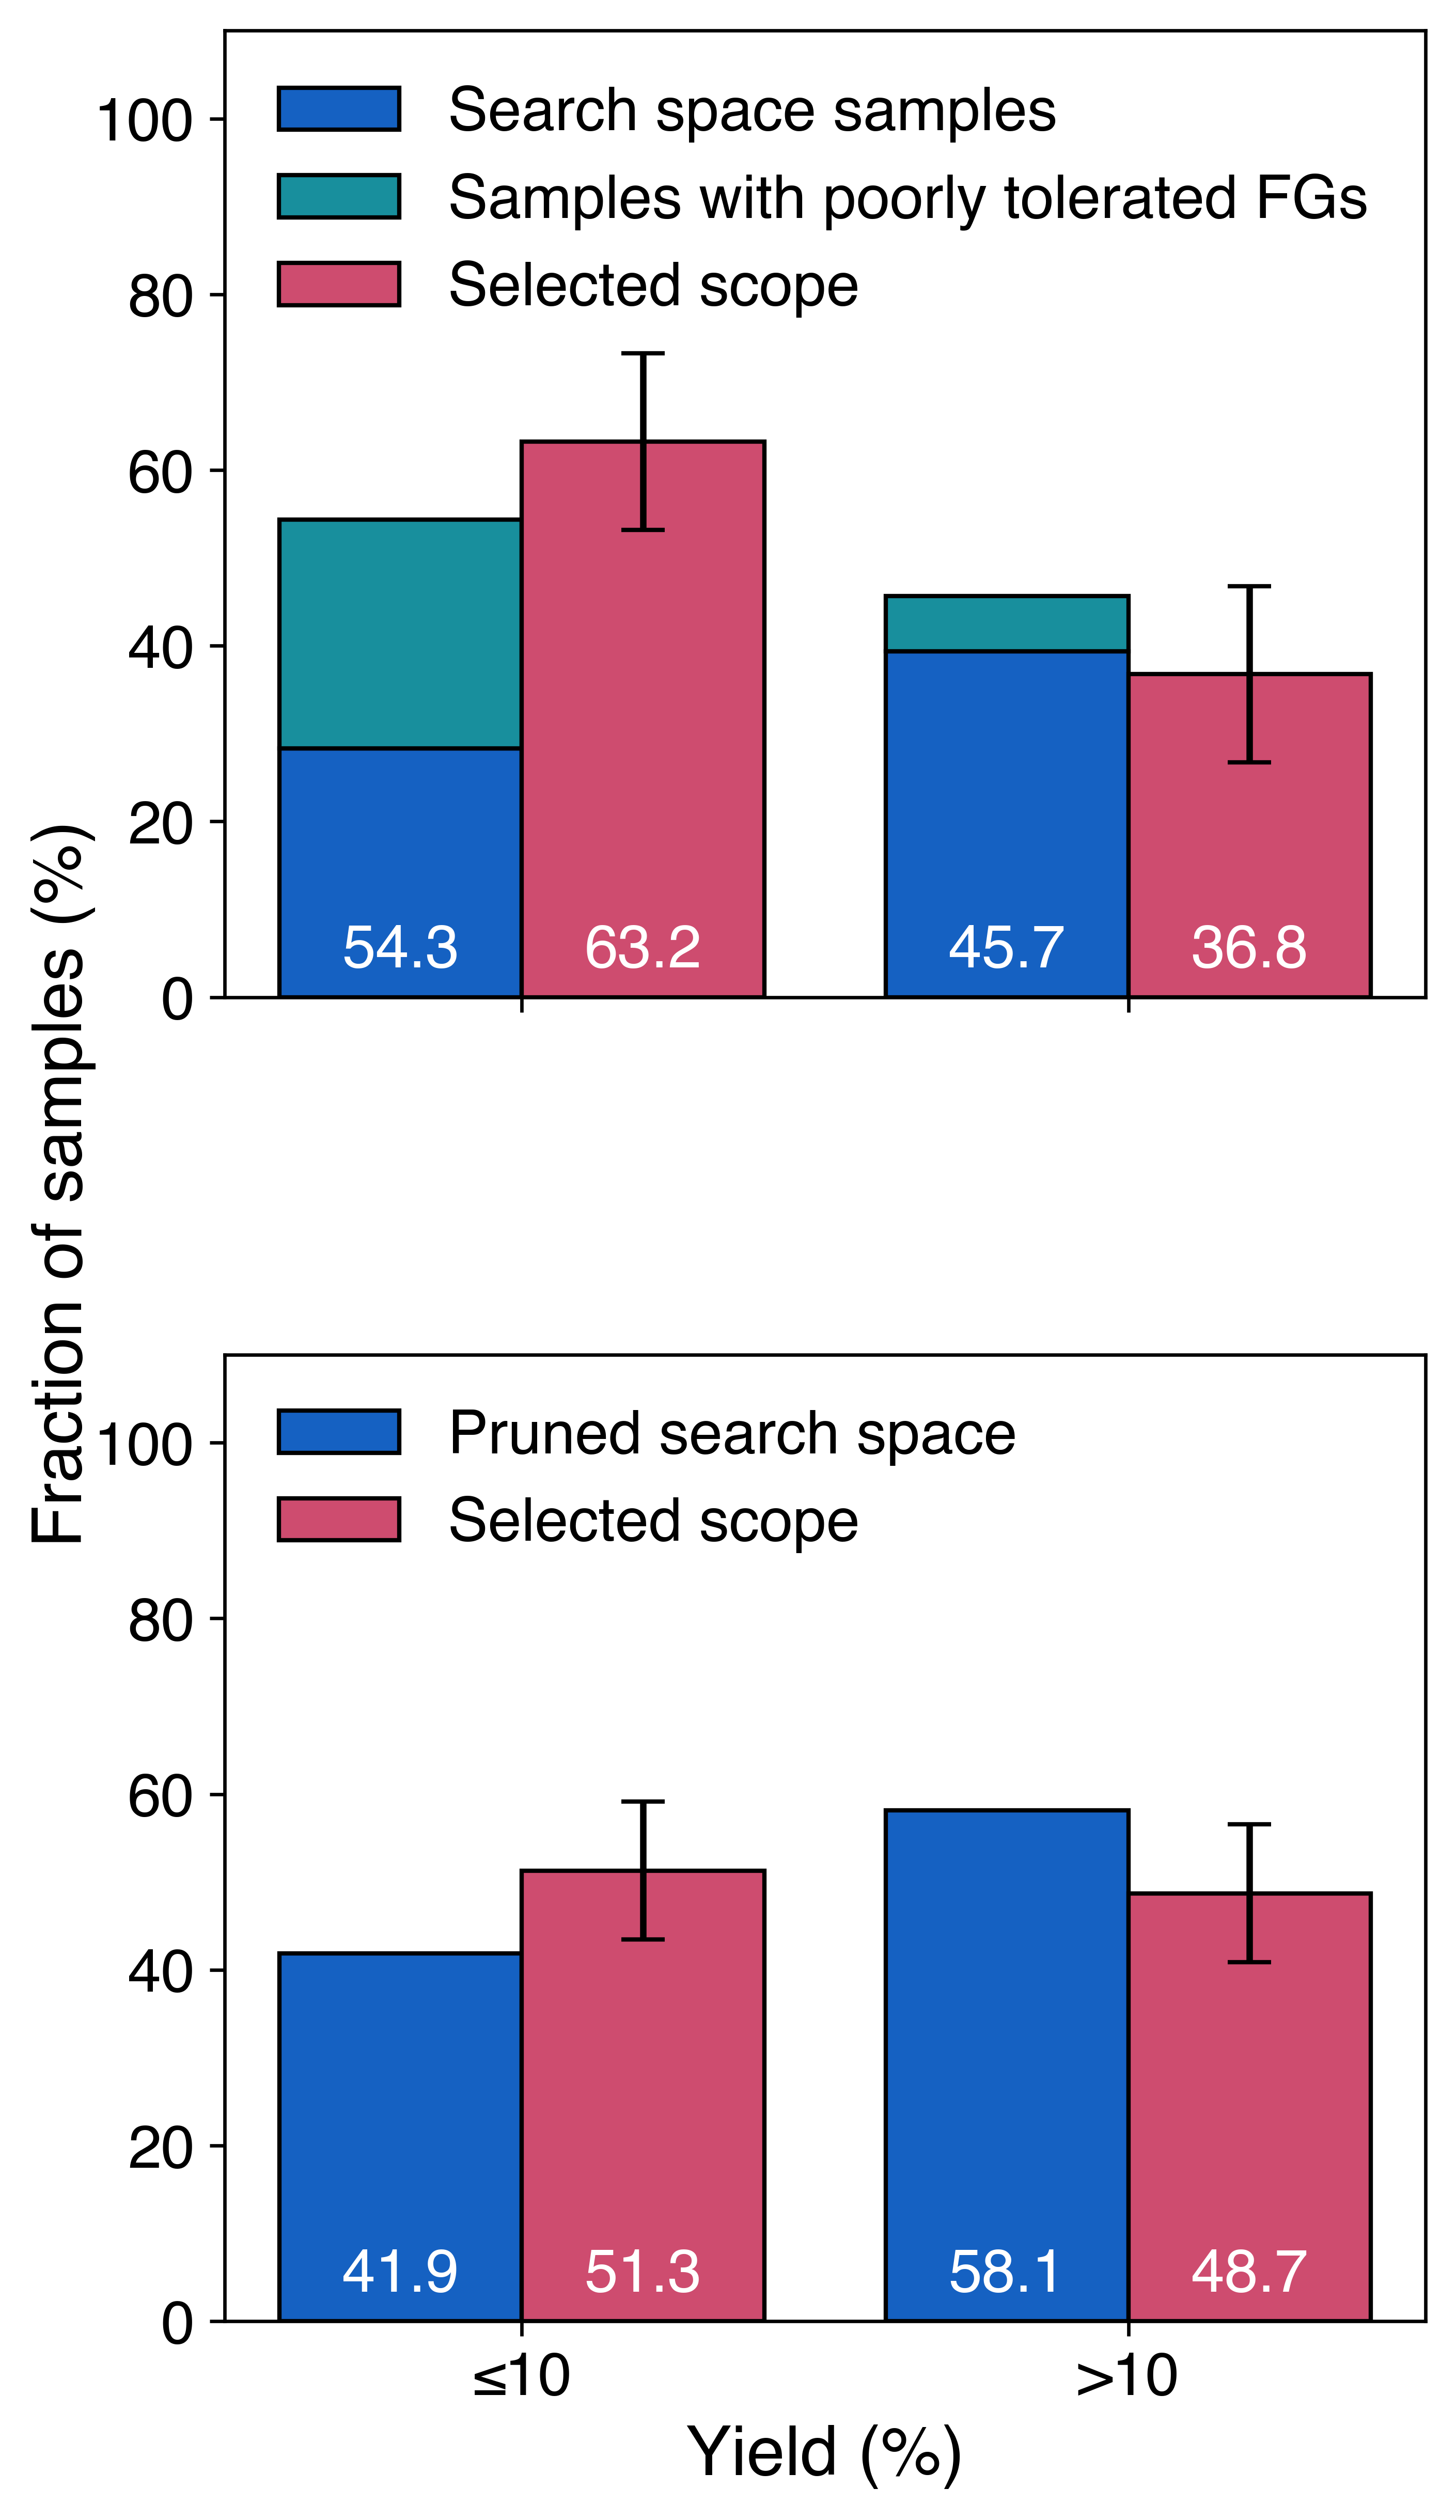

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(5, 9.79), dpi=600, sharex=True, sharey=True, gridspec_kw={"hspace": 0.37})
fig.supylabel("Fraction of samples (%)",fontsize = 16, x = 0.0)

width = 0.4
x = np.array([0,1])

bar1 = axs[0].bar(x - width/2, adj_counts(counts_remaining), width, label='Search space samples',
        color=all_colors[1], edgecolor='k')
bar2 = axs[0].bar(x - width/2, adj_counts(counts_removed), bottom = adj_counts(counts_remaining), width = width, label='Samples with poorly tolerated FGs',
        color=all_colors[2], edgecolor='k')
bar3= axs[0].bar(x + width/2, means_original_bin, width, yerr=stdevs_original_bin,
        capsize=5, label='Selected scope',
        color=all_colors[0], edgecolor='k')
axs[1].bar(x - width/2, adj_counts(counts_pruned), width, label='Pruned search space',
        color=all_colors[1], edgecolor='k')
axs[1].bar(x + width/2, means_pruned_bin, width, yerr=stdevs_pruned_bin,
        capsize=5, label='Selected scope',
        color=all_colors[0], edgecolor='k')

for data_counter,ax in enumerate(axs):
    ax.set_xticks(x)
    ax.set_xticklabels(["≤10",">10"])
    ax.set_ylim(0, 110)
    ax.legend(frameon=False,loc="upper left")

    counts = adj_counts(counts_data)
    means = means_original_bin
    if data_counter == 1:
        counts = adj_counts(counts_pruned)
        means = means_pruned_bin

    for i, v in enumerate(counts):
        ax.text(x[i] - width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=14, c="white")
    for i, v in enumerate(means):
        ax.text(x[i] + width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=14, c="white")

axs[-1].set_xlabel('Yield (%)')
plt.tight_layout()
plt.show()
